# Correlation Power Analysis (CPA)

This more powerful attack allows to quickly retrieve keys. You will use datasets already acquired in DPA lab session and demonstrate that CPA is indeed much faster, that it requires fewer traces. 

## Set-up + Data sets

### Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt 
import time

from tqdm import tnrange

In [2]:
# AES SBOX as an array
SBOX = np.array([
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5,
    0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0,
    0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc,
    0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a,
    0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0,
    0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b,
    0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85,
    0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5,
    0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17,
    0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88,
    0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c,
    0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9,
    0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6,
    0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e,
    0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94,
    0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68,
    0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16], dtype=np.int64)

 ### Load and select datasets on which you will work

In [3]:
# load traces
traces_exp = np.load("./acqui/tracesAES.npy")
plaintexts_exp = np.load("./acqui/plaintexts.npy")

traces_simu = np.load("./simu/traces_simu.npy")
plaintexts_simu  = np.load("./simu/plaintexts.npy")

In [4]:
traces = traces_simu
messages = plaintexts_simu

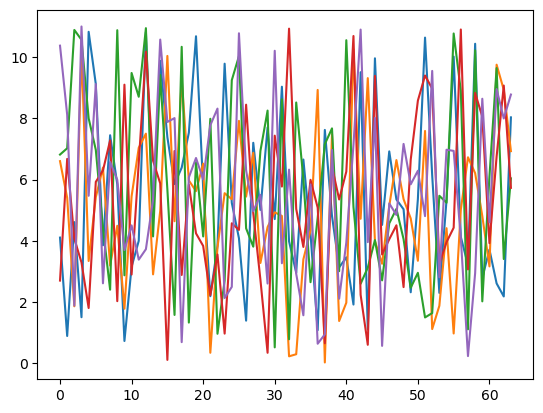

In [5]:
plt.plot(traces_simu[:5].T)
plt.show()

In [6]:
print(plaintexts_simu[:5])

[[252 216  49  40 223 127 209  53 118 251  73 247  29 175  38 102]
 [ 78 177  11   7 157  75  32   1 138 103  10 230  81  13  55  70]
 [ 29 152   2 228  96 179 196  80 236 132 236  99  75 162   3 146]
 [235  94  68 113 227  75  15  94 170 233 165 221 177 157 233 255]
 [134  77 234 121  60 150 154 216 214 192  37  80  97 236  32  92]]


## CPA  implementation

CPA measures the correlation between a specific expected/theoretical model and the actual/experimental traces. For a given key guess, the higher the correlation, the more likely the key guess is. As in DPA attack, we will work byte by byte (divide and conquer strategy) and target the same output (after the first SBox).

The figure belows shows the principle and steps of this attack.
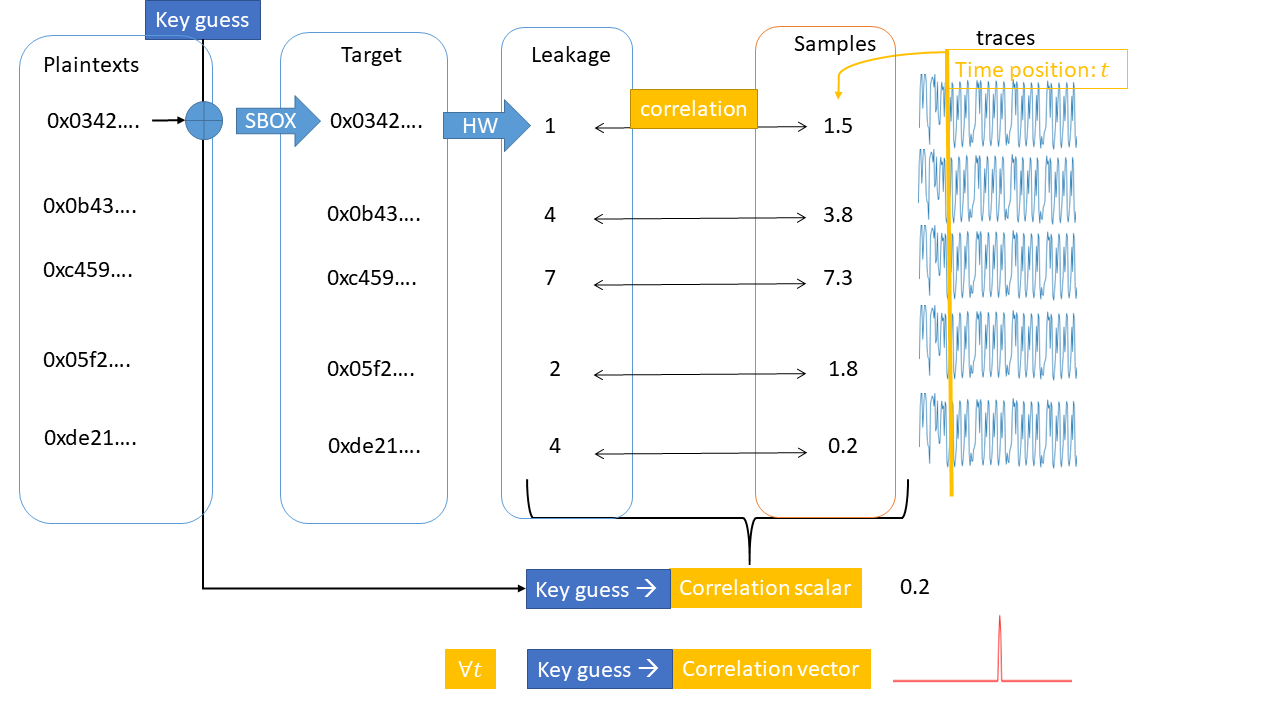

###  Hamming weight leakage model

In this lab, we will use the hamming weight leakage which is the more common leakage model. 
1. Define the `hamming_weight` function which outputs the number of "1" in the binary reprensentation of a number. 


In [7]:
def hamming_weight(x):
     return bin(x).count('1')

Sanity checks

In [8]:
assert(hamming_weight(0b10111011) == 6)
assert(hamming_weight(0x55) == 4)

2. Define `sel_hamming` which returns the hamming_weight of the target, i.e. HW of the ouput of the first SBox, with a known `message` (16 bytes) , key `guess` (1 single byte) for a specific `byte` position (from 0 to 15).

In [9]:
def sel_hamming(message, guess, byte):
    out = SBOX[message[byte] ^ guess]
    return  hamming_weight(out)#a single byte

In [10]:
assert(sel_hamming(messages[0], 0, 0) == 3)
assert(sel_hamming(messages[2], 0x65, 4) == 5)

Now you can calculate this hamming weight for all the messages and obtain the vector at the right hand side of the CPA schematics=. 

2. Calulate the value of the leakage model vector for all the messages for a given key guess. 


In [11]:
def leakage_model(messages, guess, byte):
    leak_vector = []
    for m in messages:
        leak_vector.append(sel_hamming(m,guess,byte))
    return leak_vector

### Correlation

CPA measures the correlation between experiments and the leakage model. We will first implement this correlation at one time position and then extrapolates this correlation for all time samples. 

#### correlation coefficient of 2 vectors

We will use Pearson `correlation` coefficient to measure the correlation between 2 vectors of lenght $N$,  $X = \sum_i X_i$ and $Y = \sum_i Y_i$. This coefficient corresponds to a normalized covariance of the 2 vectors:

$$ corr = \frac{cov(X, Y)} {\sigma_X \sigma_Y} $$

where 

$$ \sigma_X = \sqrt{var(X)} =  \sqrt{\sum_i (X_i - \bar{X})^2}$$ where $$  X = 1/N \sum_{i=0}^{N-1} X_i $$
and 

$$ cov(X, Y) = \sum_i (X_i - \bar{X})(Y_i - \bar{Y})  $$

You can use numpy functions `np.mean`, `np.var`, `np.sqrt` to calculate the corr coefficient as they are faster and optimized for vectors. 

In [12]:

def corr(xv,yv):
    ''' xv, yv vectors
    returns scalar, correlation coefficient of the two vectors
    '''
    x_mean = np.mean(xv)
    y_mean = np.mean(yv)
    x_stdv =  np.sqrt(np.var(xv))
    y_stdv =  np.sqrt(np.var(yv))
    
    cov = 0
    l = min(len(xv),len(yv))
    for i in range(0,l):
        cov += ((xv[i]-x_mean)*(yv[i]-y_mean))
        
    cov = cov / (len(xv))
        
    return cov/(x_stdv*y_stdv)


1.0
-0.054916606074762786


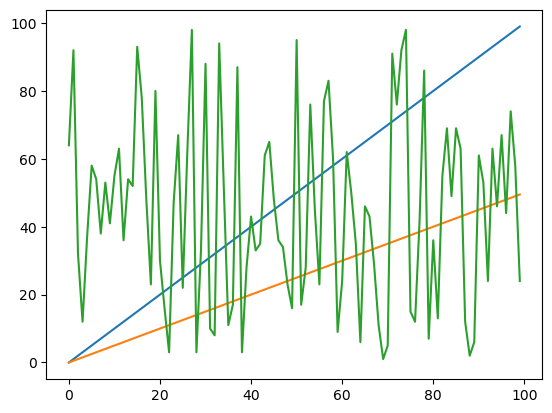

In [13]:
a = np.arange(100)
b = 0.5 * np.arange(100)
c = np.random.randint(0, 100, 100)
print(corr(a,b))
print(corr(a,c))
assert(corr(a,b) == 1)
assert(corr(a,c) < 0.2)
plt.figure()
plt.plot(a)
plt.plot(b)
plt.plot(c)
plt.show()

### Correlation between traces and leakage model

Calculate the correlation function at time position 18, for byte 0 in the simulated traces for all possible key guesses, and retrieve the correct key. This corresponds to the leakage scalar in the CPA figure. 


In [14]:
def correlation(guess, time_pos, byte):
    vector = leakage_model(messages, guess, byte)
    
    trace_at_timepos = []
    for t in range(0,len(traces)):
        trace_at_timepos.append(traces[t,time_pos])
    
    correl = corr(vector, trace_at_timepos)
    return correl

In [15]:
def correlation_guesses(guesses, time_pos, byte):
    res = []
    for g in guesses:
        res.append(correlation(g, time_pos, byte))
        
    return np.array(res) # a vector of correlation for every key guesses

In [16]:
print("Correct key byte is ", correlation_guesses(np.arange(256), 18, 0).argmax())

Correct key byte is  32


In order to finish the correlation vector we will need to calculate this correlation vector for all time position. You could do this with a loop but we would better use numpy acceleration and use the same functions with an axis parameters. 

For instance `traces.sum(axis=0)` will calculate the mean value of the columns of the traces, which correponds to the mean value at a given time position. This is what we need. The only issue might be the leakage model vector which is not a matrix, but youn can convert it to a matrix by returning an np.array of leakage model. 

In [17]:
def corr_vect(xmat, ymat):
    ''' xmat, ymat
    returns vector correlation coefficient of the two matrices
    '''
    corr_vector = np.zeros(xmat.shape[1])
    
    for col in range(0,xmat.shape[1]):
        corr_vector[col] = corr(xmat[:,col],ymat[:,col])
   
    return corr_vector

In [18]:
def guess_correlation(guess, messages, traces, leakage_fnct):
    # for every time positions and a specific guess
    
    leakage = leakage_fnct(messages,guess)
    extension = np.tile(leakage,(traces.shape[1],1)).T
    
    #print(leakage)
    #print(extension)
    #print(traces)
    
    
    
    return corr_vect(extension,traces)


Sanity plot checks

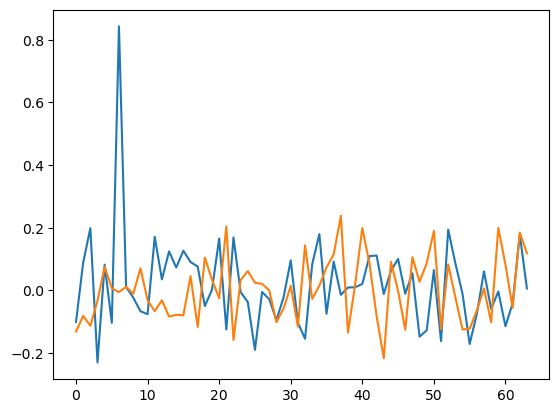

In [19]:
nb_traces = 100
res = guess_correlation(0, messages[:nb_traces,:], traces[:nb_traces,:], lambda m,g :leakage_model(m, g, 0))
plt.plot(res)
res = guess_correlation(0x61, messages[:nb_traces,:], traces[:nb_traces,:], lambda m,g :leakage_model(m, g, 0))
plt.plot(res)
plt.show()

### CPA result
Return the CPA matrix, which corresponds to guess_correlation for every key guesses, like DPA matrix.
Determine the key. 

('Correct key byte is ', 0)


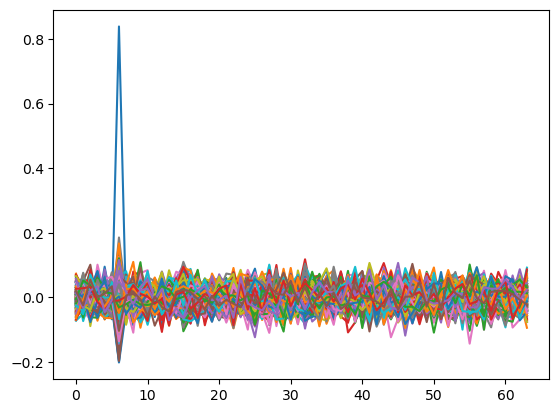

In [20]:
def cpa(guesses, messages, traces, model_fnct):
    
    cpa_vec = []
    for guess in guesses:
        cpa_vec.append(guess_correlation(guess, messages, traces, model_fnct))
    
    return np.array(cpa_vec)


res = cpa(np.arange(256), messages, traces, lambda m,g :leakage_model(m, g, 0))
print(("Correct key byte is ", res.max(1).argmax()))
plt.plot(res.T)
plt.show()

Determine all the key bytes.

In [22]:

key_list = []

for pos in range(16):
    res = cpa(np.arange(256), messages, traces, lambda m,g :leakage_model(m, g, pos))
    print("Key byte " + str(res.max(1).argmax()))
    key_list.append(np.argmax(np.max(res,axis=1)))


Key byte 0
Key byte 1
Key byte 2
Key byte 3
Key byte 4
Key byte 202
Key byte 254
Key byte 7
Key byte 222
Key byte 192
Key byte 13
Key byte 237
Key byte 12
Key byte 13
Key byte 14
Key byte 15


# Comparison with DPA

The goal is to compare 2 different type of attacks and assess the fastest. Choose a byte to attack and determine how many curves are needed for CPA and for DPA to retrive this key byte.

The best way to illustrate the two attacks is to plot the correct key rank versus number of curves;

## Rank CPA



In [29]:
def rank_cpa_byte(key, key_byte_index, traces, messages):
    cpa_out = cpa(np.arange(256), messages, traces, lambda m, g :leakage_model(m, g, key_byte_index))
    ranks = np.argsort(np.max(cpa_out, axis=1))[::-1]

    rank_key_byte = np.where(ranks==key[key_byte_index])

    
    return rank_key_byte[0][0]

def rank_cpa(key, nb_traces, traces, messages):
    rank = 0
    for key_byte_index in range(16):
        rank += rank_cpa_byte(key, key_byte_index, traces, messages)

    return rank / 16


## Compare with DPA

Copy the DPA function from previous lab to get the correct key rank wih respect to the number of traces. 

In [32]:
def target_function(msg, key, byte_i):
    return SBOX[msg ^ key][byte_i]

def leakage_function(byte_i, bit_j):
    return (byte_i >> bit_j) & 1  

def selection(msg, key, byte_i, bit_j):
    return leakage_function(target_function(msg, key, byte_i), bit_j)

def sel0(msg, key, byte_i):
    return selection(msg, key, byte_i, 0)

def hypothesis(guess, messages, traces, selection_function):
    h0 = np.zeros(len(traces[0]), dtype = np.float64)
    h1 = np.zeros(len(traces[0]), dtype = np.float64)
    
    h0count = 0
    h1count = 0
    for trace, message in zip(traces, messages):
        bit = selection_function(message, guess)
        if bit:
            h1 += trace
            h1count += 1
        else:
            h0 += trace
            h0count += 1
    
    if h0count == 0:
        mean0 = 0
    else:
        mean0 = (h0 / h0count)
        
    if h1count == 0:
        mean1 = 0
    else:
        mean1 = (h1 / h1count)
    
    return np.abs(mean0 - mean1)

def dpa(guesses, messages, traces, selection_function):
    mat = np.zeros((256, len(traces[0])), dtype = np.float64)
    
    for index, key_guess in enumerate(guesses):
        mat[index] = hypothesis(key_guess, messages, traces, selection_function)
    
    return mat 

def rank_dpa_byte(key, key_byte_index, traces, messages):
    dpa_out = dpa(range(0, 256), messages, traces, lambda m, g: sel0(m, g, key_byte_index))
    ranks = np.argsort(np.max(dpa_out, axis=1))[::-1]

    rank_key_byte = np.where(ranks==key[key_byte_index])

    return rank_key_byte[0][0]

def rank_dpa(key, nb_traces, traces, messages):
    rank = 0
    for key_byte_index in range(16):
        rank += rank_dpa_byte(key, key_byte_index, traces, messages)

    return rank / 16


## Plots

/tmp/ipykernel_18136/1315988392.py:17: RuntimeWarning: invalid value encountered in double_scalars
  return cov/(x_stdv*y_stdv)


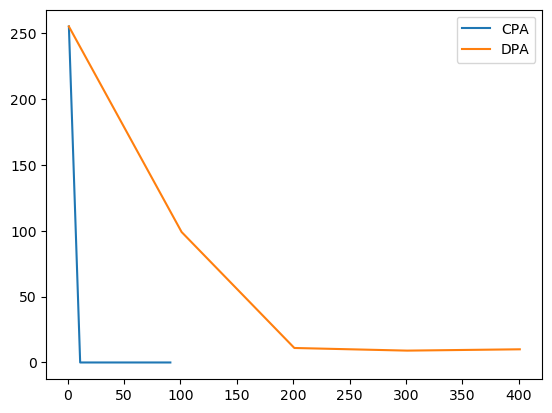

In [31]:
correct_key = [0,1,2,3,4,202,254,7,222,192,13,237,12,13,14,15 ]
plt.figure()

key = bytearray(correct_key)

xc = range(1, 100, 10)
yc = [rank_cpa_byte(key, 0, traces[:nb,:], messages[:nb,:]) for nb in xc]
plt.plot(xc, yc, label="CPA")

xd = range(1, 500, 100)
yd = [rank_dpa_byte(key, 0, traces[:nb,:], messages[:nb,:]) for nb in xd]
plt.plot(xd, yd, label="DPA")

plt.legend()
plt.show()
